In [343]:
%matplotlib inline 
from skimage import data, img_as_float
from skimage.color import rgb2hsv
from skimage.io import imread, imshow, show

import numpy as np
import matplotlib.pyplot as plt

In [344]:
def show_images(data, small=False, colormap=False):
    ldata = len(data)
    if small:
        fig = plt.figure(figsize=(20, 20))
    else:
        fig = plt.figure(figsize=(20, 10 * ldata))

    for i, (im, cmap) in enumerate(data, start=1):
        if small:
            ax = fig.add_subplot(1, ldata, i, xticks=[], yticks=[])
        else:
            ax = fig.add_subplot(ldata, 1, i, xticks=[], yticks=[])
        _img = ax.imshow(im, cmap=cmap)
        if colormap:
            plt.colorbar(_img, fraction=0.046, pad=0.04, shrink=1.0)
    if small:
        fig.show()

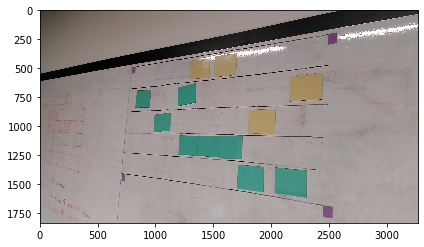

In [345]:
img = img_as_float(imread("c.jpg"))
imshow(img)
show()

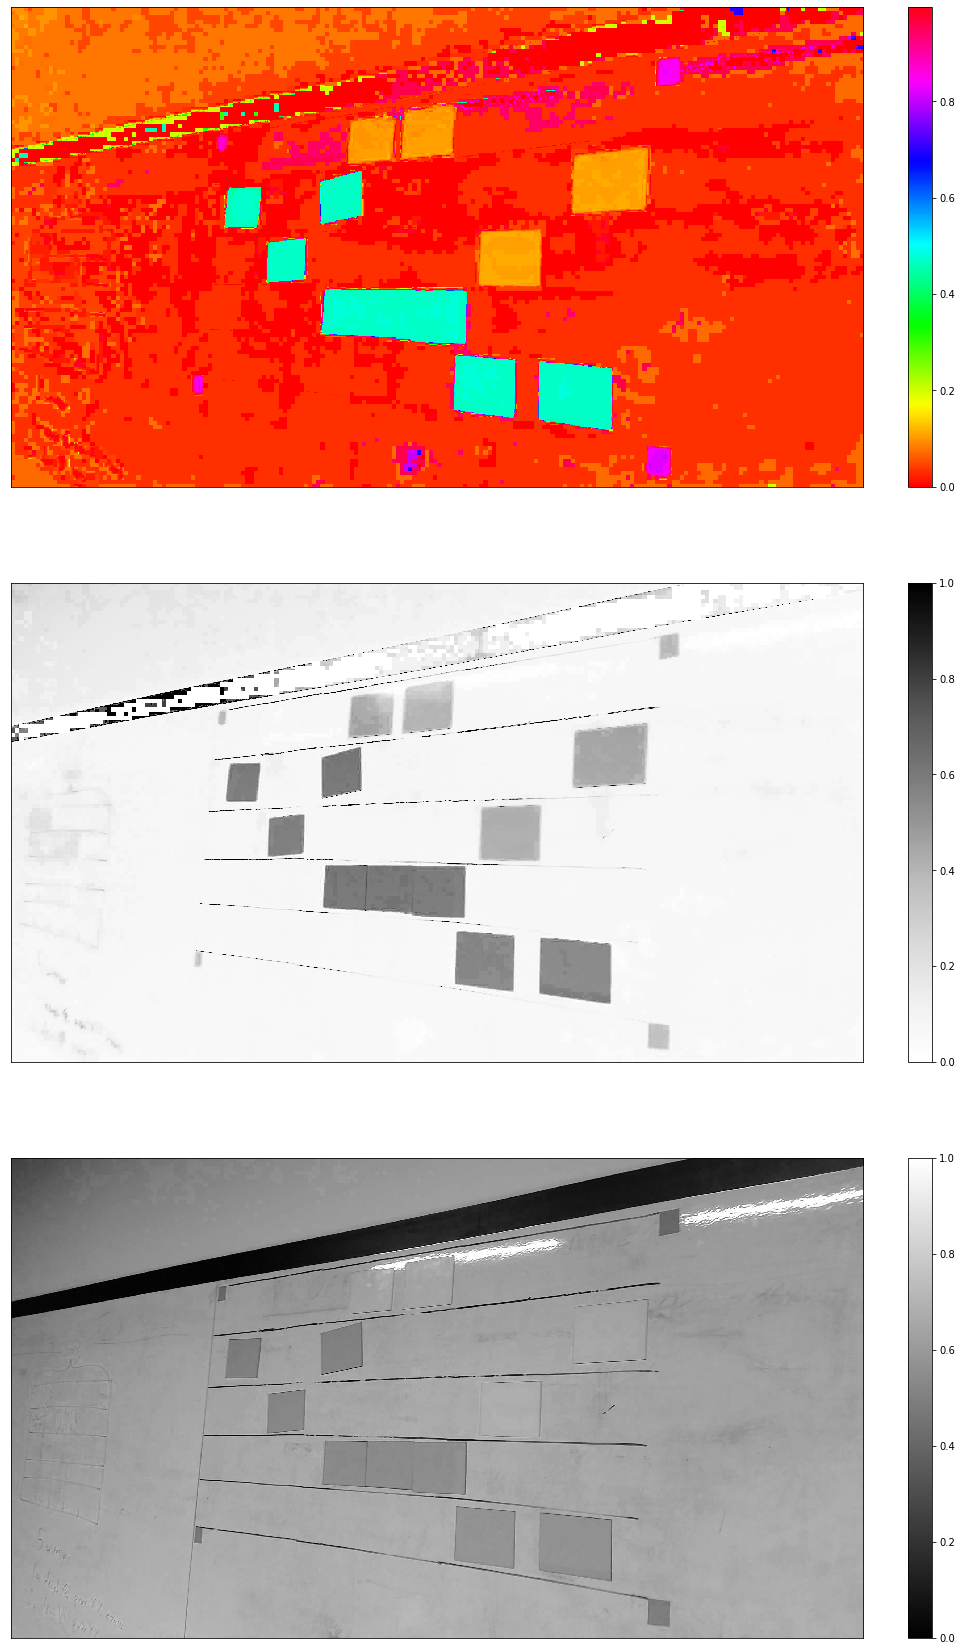

In [346]:
hsv = rgb2hsv(img)
h = hsv[:,:,0]
s = hsv[:,:,1]
v = hsv[:,:,2]

show_images([
    (h, 'hsv'),
    (s, 'Greys'),
    (v, 'gray'),
], colormap=True)

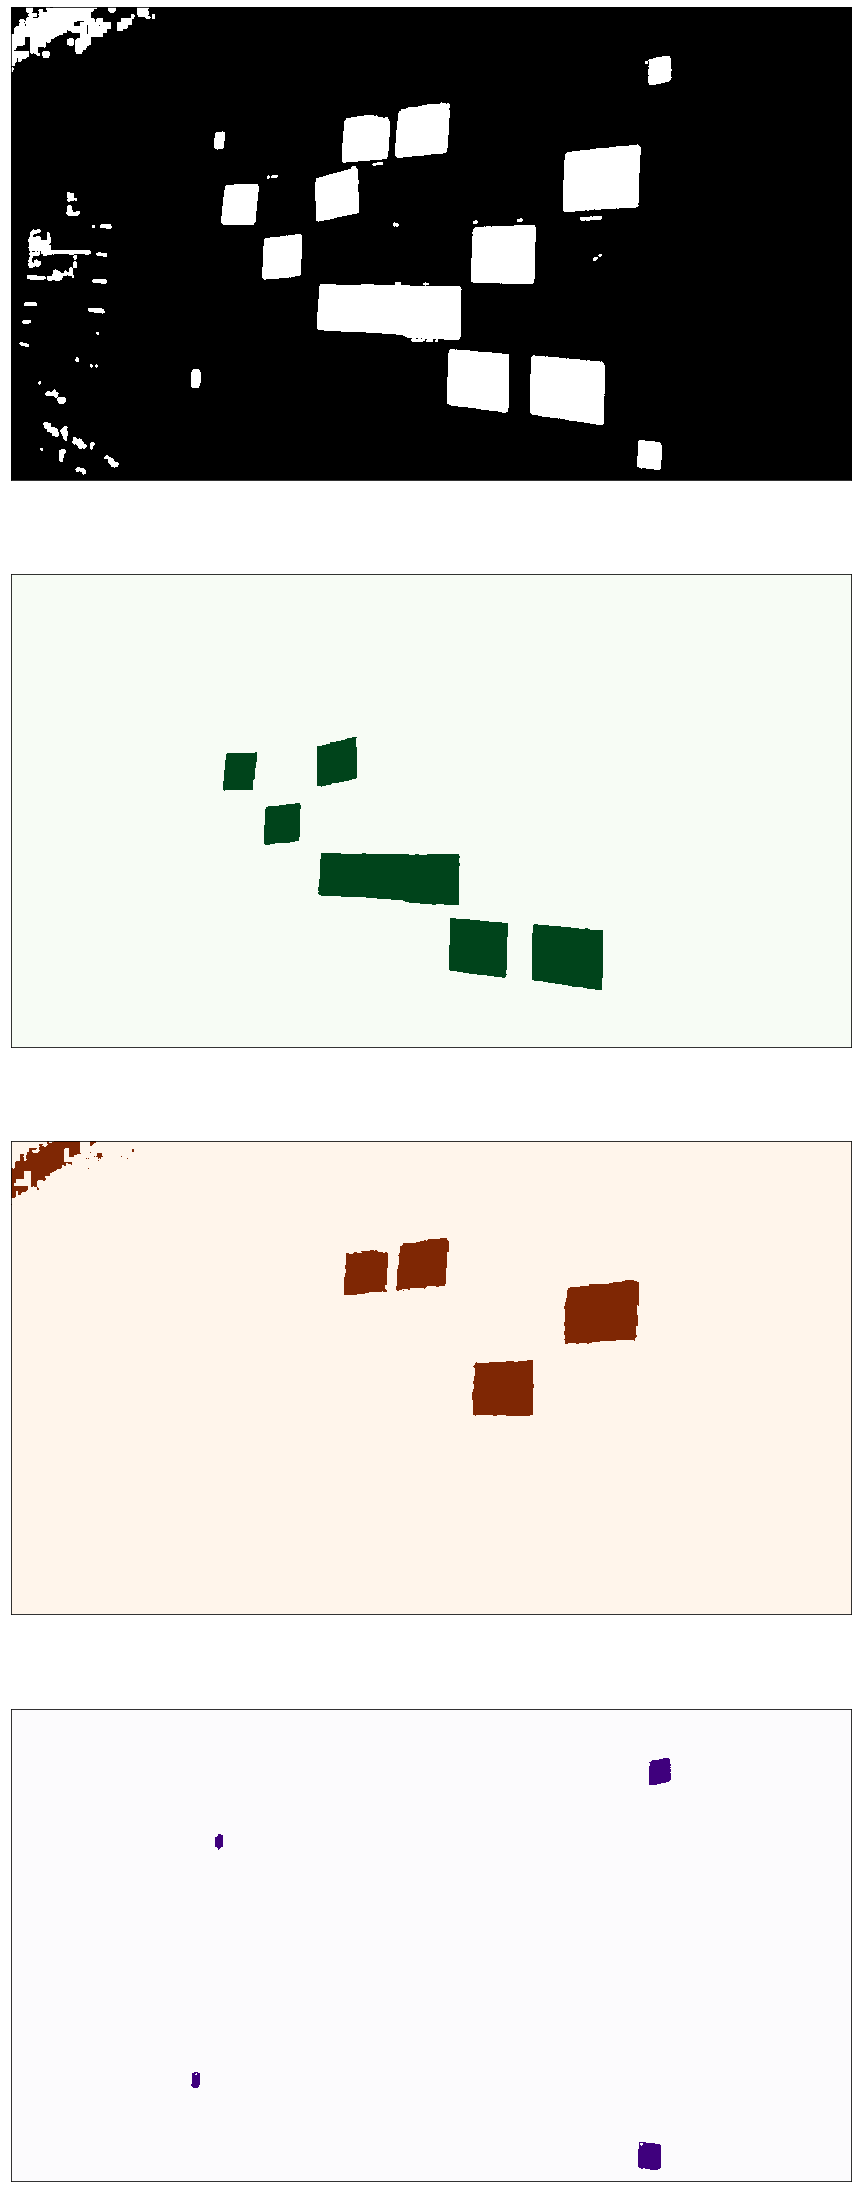

In [347]:
from skimage.color import label2rgb
from skimage.measure import label
from skimage.morphology import dilation, erosion, disk
import numpy as np

mini_selem = disk(3)
selem = disk(6)
land, lor = np.logical_and, np.logical_or

#lines = dilation(v < 0.4, selem)

blocks = land(s > 0.2, v > 0.3)
blocks = dilation(blocks, selem)

def rr(hstart, hend):
    x = land(blocks, land(h > hstart, h < hend))
    return erosion(x, mini_selem)
    
green_blocks = rr(0.4, 0.6)
yellow_blocks = rr(0.05, 0.2)
purple_blocks = rr(0.8, 0.95)

show_images([
    #(lines, 'gray'),
    (blocks, 'gray'),
    (green_blocks, 'Greens'),
    (yellow_blocks, 'Oranges'),
    (purple_blocks, 'Purples'),
])

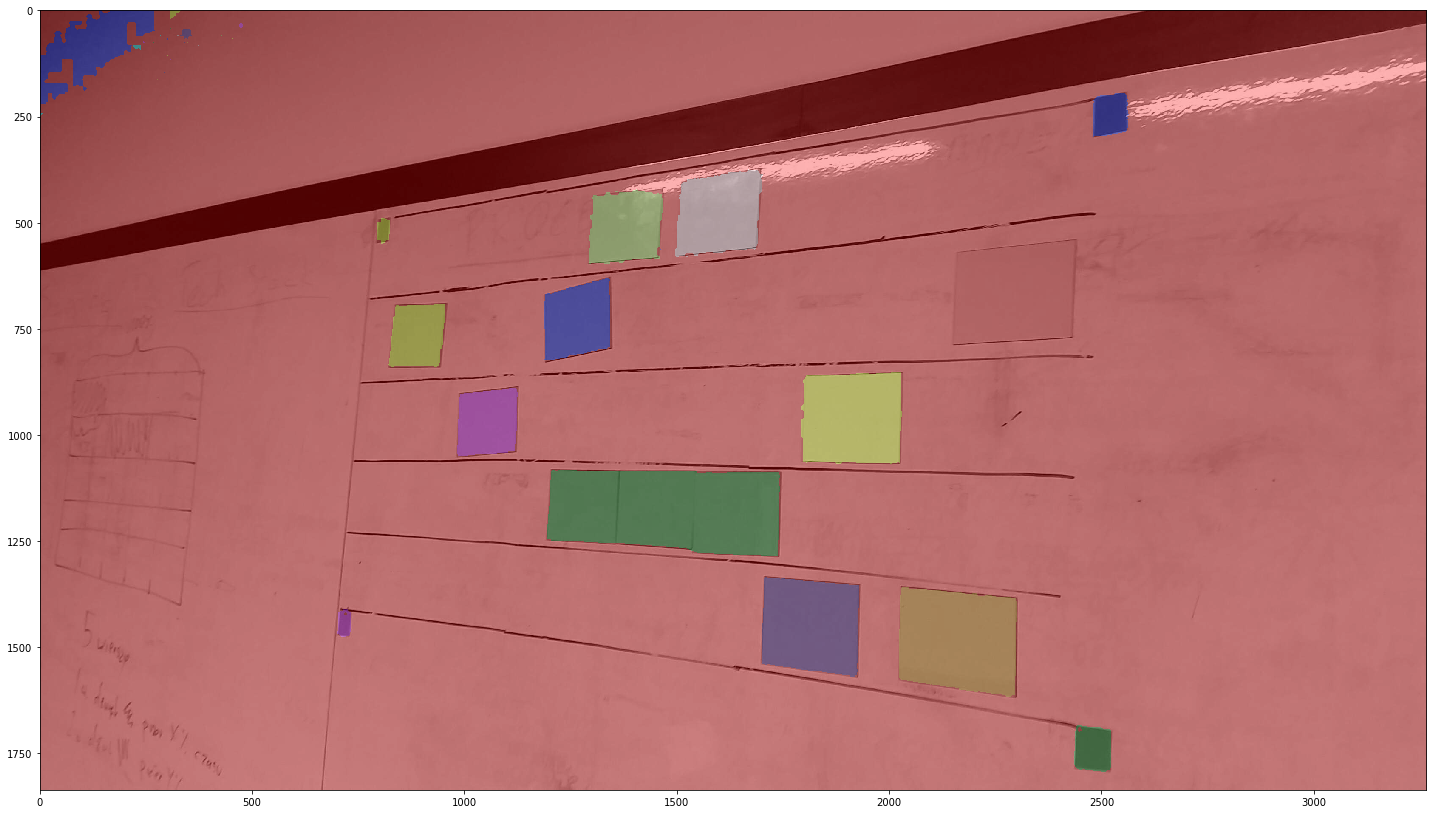

In [348]:
from skimage.color import label2rgb
from skimage.measure import label, regionprops

green_labels = label(green_blocks)
yellow_labels = label(yellow_blocks)
purple_labels = label(purple_blocks)
all_labels = green_labels + yellow_labels + purple_labels
image_label_overlay = label2rgb(all_labels, image=img)

fig = plt.figure(figsize=(20, 20))
imshow(image_label_overlay)

In [349]:
def show_labels(title, labels):
    print(title)
    for region in regionprops(labels):
        minr, minc, maxr, maxc = region.bbox
        medium_y = (minr + maxr) / 2.0
        start_x = minc
        length = maxc - minc
        print(f'* area: {region.filled_area:8.2f}, y: {medium_y:8.2f}, start-x: {start_x:8.2f}, length: {length:8.2f}')
        
show_labels('GREEN', green_labels)
show_labels('YELLOW', yellow_labels)
show_labels('PURPLE', purple_labels)

GREEN
* area: 24639.00, y:   728.50, start-x:  1187.00, length:   154.00
* area: 17297.00, y:   766.00, start-x:   820.00, length:   134.00
* area: 20371.00, y:   970.00, start-x:   981.00, length:   143.00
* area: 97314.00, y:  1184.50, start-x:  1192.00, length:   549.00
* area: 47039.00, y:  1452.00, start-x:  1699.00, length:   229.00
* area: 61759.00, y:  1487.00, start-x:  2022.00, length:   276.00
YELLOW
* area: 26837.00, y:   110.50, start-x:     0.00, length:   270.00
* area:   292.00, y:    11.00, start-x:   307.00, length:    24.00
* area:    92.00, y:    36.00, start-x:   469.00, length:     8.00
* area:     5.00, y:    43.50, start-x:   307.00, length:     3.00
* area:   432.00, y:    57.50, start-x:   330.00, length:    28.00
* area:     5.00, y:    52.50, start-x:   282.00, length:     3.00
* area:     5.00, y:    59.50, start-x:   282.00, length:     3.00
* area:     5.00, y:    59.50, start-x:   323.00, length:     3.00
* area:     5.00, y:    59.50, start-x:   426.00,

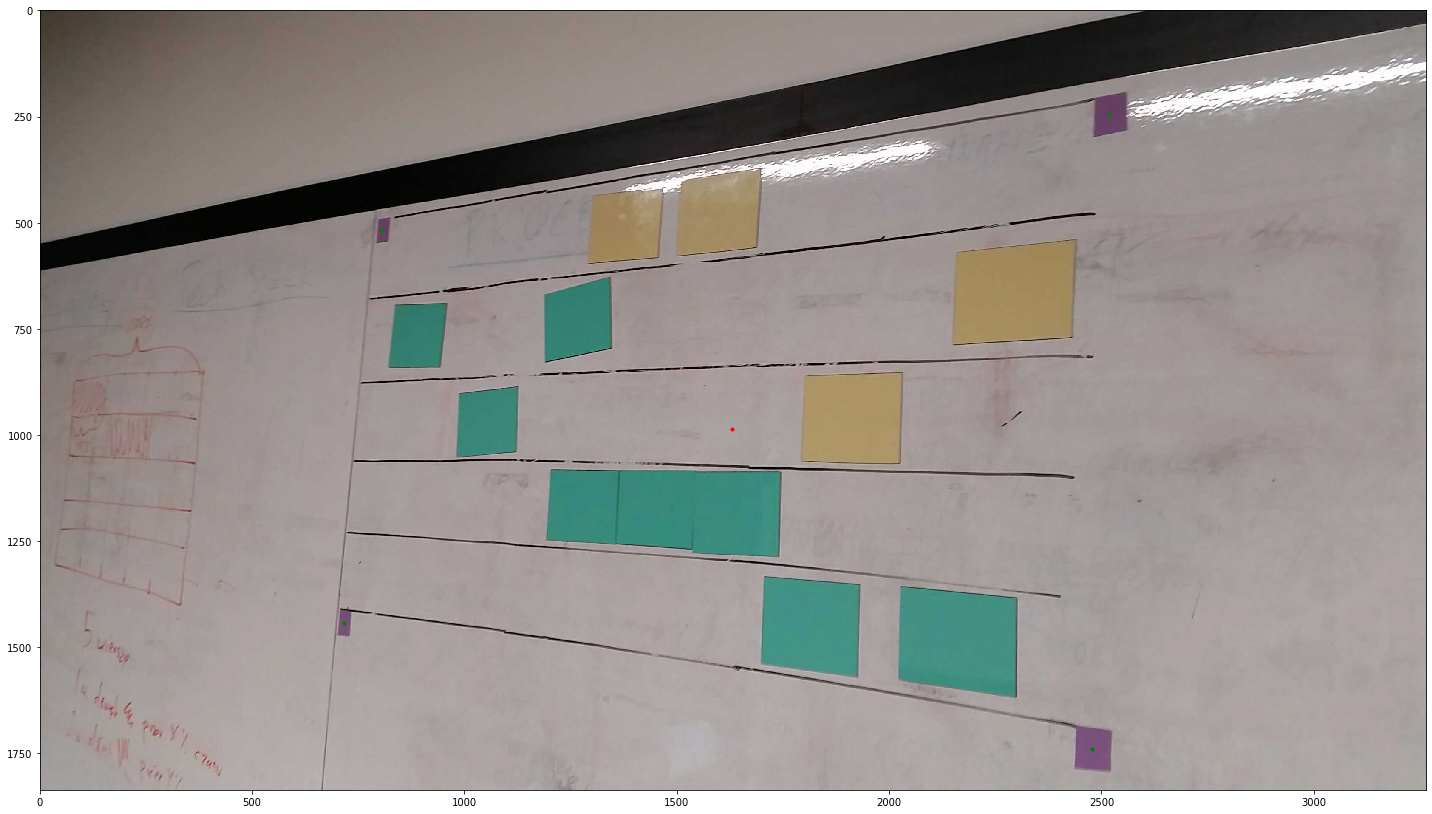

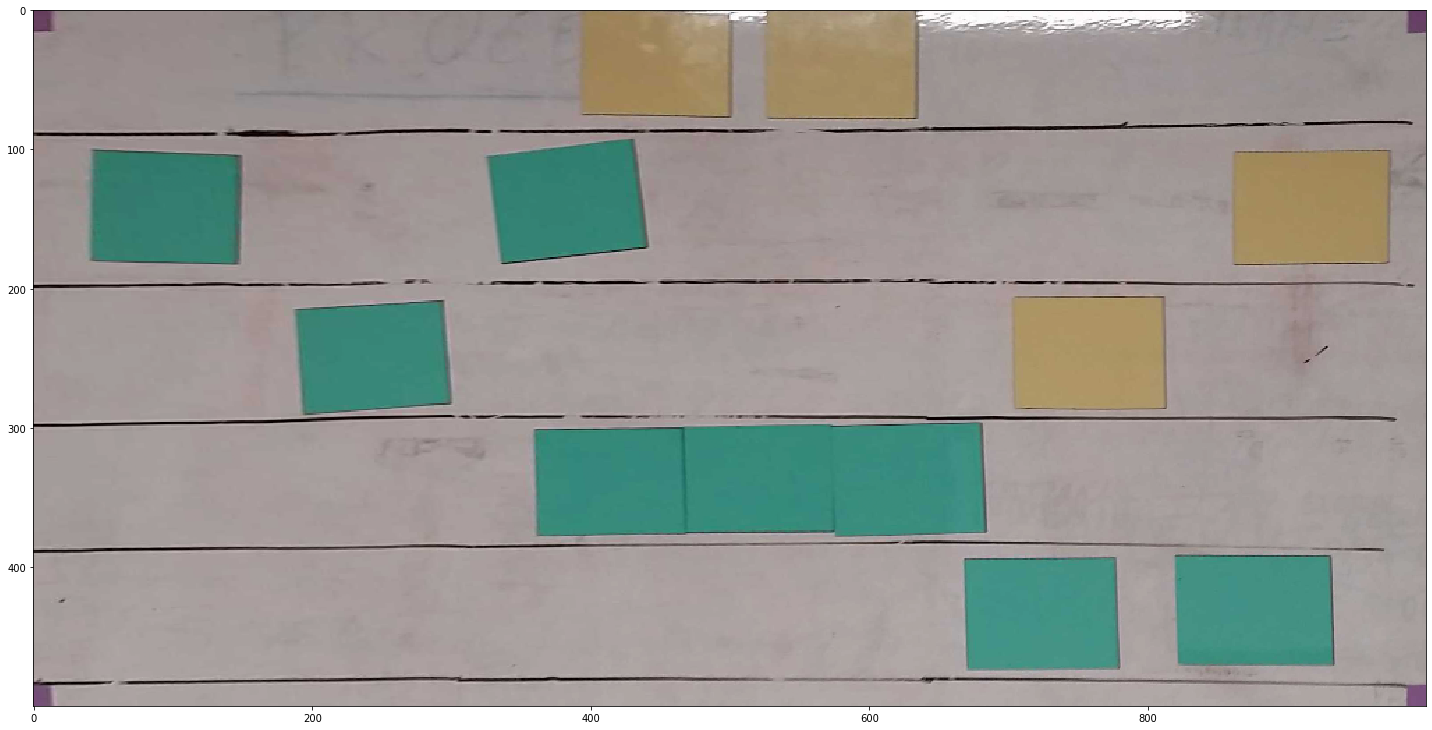

In [351]:
from skimage.transform import ProjectiveTransform, warp

WIDTH, HEIGHT = 1000, 500
dst_points = np.array([(0, 0)] * 4)
src_points = np.array([
    (0, 0),
    (0, HEIGHT),
    (WIDTH, HEIGHT),
    (WIDTH, 0),
])

tmp_points = []
for region in regionprops(purple_labels):
    y, x = region.centroid
    tmp_points.append((x, y))
    
cenx = sum(x for x, y in tmp_points) / 4.0
ceny = sum(y for x, y in tmp_points) / 4.0
UP_LEFT, DOWN_LEFT, DOWN_RIGHT, UP_RIGHT = range(4)
def get_corner_index(x, y):
    if y < ceny:
        if x < cenx:
            return UP_LEFT
        else:
            return UP_RIGHT
    else:
        if x < cenx:
            return DOWN_LEFT
        else:
            return DOWN_RIGHT

for x, y in tmp_points:
    corner_index = get_corner_index(x, y)
    dst_points[corner_index] = (x, y)

tform = ProjectiveTransform()
tform.estimate(src_points, dst_points)
warped = warp(img, tform, output_shape=(HEIGHT, WIDTH))
    
fig = plt.figure(figsize=(20, 20))
imshow(img)
plt.plot(dst_points[:, 0], dst_points[:, 1], '.g')
plt.plot(cenx, ceny, '.r')
show()
fig = plt.figure(figsize=(20, 20))
imshow(warped)